In [32]:
import numpy as np
import matplotlib.pyplot as plt
import admm_fq_base as adfb
import asilomar2023sim.src.admm_fq_huffman as adfvar
import utils
import importlib

def getPart(index) -> int:
    return int(np.floor(index / part_len))

In [ ]:
importlib.reload(adfb)
importlib.reload(adfvar)
importlib.reload(utils)

In [ ]:
rng = np.random.default_rng()
L = 16

In [ ]:
nwb = adfb.Network(L)
nwb.addNode(0, 1.0)
nwb.addNode(1, 1.0)
nwb.addNode(2, 1.0)
nwb.setConnection(0, [1])
nwb.setConnection(1, [2])
nwb.setConnection(2, [0])

nwvar = adfvar.Network(L)
nwvar.addNode(0, 1.0)
nwvar.addNode(1, 1.0)
nwvar.addNode(2, 1.0)
nwvar.setConnection(0, [1])
nwvar.setConnection(1, [2])
nwvar.setConnection(2, [0])

# nwpr = adfpr.Network(L)
# nwpr.addNode(0)
# nwpr.addNode(1)
# nwpr.addNode(2)
# nwpr.setConnection(0, [1])
# nwpr.setConnection(1, [2])
# nwpr.setConnection(2, [0])

# nwar = adfar.Network(L)
# nwar.addNode(0)
# nwar.addNode(1)
# nwar.addNode(2)
# nwar.setConnection(0, [1])
# nwar.setConnection(1, [2])
# nwar.setConnection(2, [0])

In [33]:
rho = 1
stepsize = 0.8
eta = 0.98
M = nwb.N
nr_samples = 100000
partitions = 2
part_len = int(nr_samples / partitions)

true_norms = [1.0, 1.0, 1.0, 1.0]

u = rng.normal(size=(nr_samples, 1))
clean_signal: np.ndarray = u / u.max()

clean_signal = clean_signal / clean_signal.std(axis=0) * 0.25

In [45]:
h = {}
hf = {}
for part in range(partitions):
    h_, hf_ = utils.generateRandomIRs(L, M, true_norms, rng)
    h[part] = h_
    hf[part] = hf_

In [48]:
SNR = 20
noisy_signals = np.empty((0, M))
for part in range(partitions):
    noisy_signals_ = utils.getNoisySignal(
        clean_signal[part * part_len : (part + 1) * part_len], h[part], SNR, rng
    )
    noisy_signals = np.concatenate([noisy_signals, noisy_signals_])

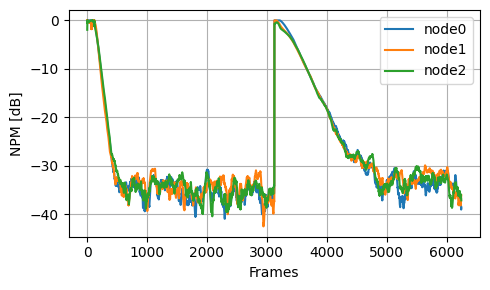

In [49]:
transmission_hist = {}
hopsize = L
npm = []
# nw.setOnTransmit(saveTransmissionHist)
nwb.reset()
nwb.setParameters(rho, stepsize, eta, 1, 0.0)
# nwb.setDeltas(1e-8, 0.1, 0.1, 2, 0.001)
for k_admm_fq in range(0, nr_samples - 2 * L, hopsize):
    nwb.step(noisy_signals[k_admm_fq : k_admm_fq + 2 * L, :])
    error = []
    for m in range(M):
        node: adfb.NodeProcessor = nwb.nodes[m]
        error.append(utils.NPM(node.getEstimate(), hf[getPart(k_admm_fq)][:, m, None]))
    # npm.append(np.mean(error))
    npm.append(error)
npm = np.asarray(npm)
nw_ = nwb

fig = plt.figure(figsize=(5, 3))
# plt.title(rf"SNR={SNR}dB")
plt.xlabel("Frames")
plt.ylabel("NPM [dB]")
labels = [f"node{label}" for label in range(M)]
plt.plot(20 * np.log10(npm), label=labels)
# plt.ylim(-50, 0)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
utils.savefig(fig, "npm")

In [ ]:
transmission_hist = {}
hopsize = L
npm = []
# nw.setOnTransmit(saveTransmissionHist)
nwvar.reset()
nwvar.setParameters(rho, stepsize, eta, 1, 0.0)
# nwvar.setDeltas(1e-8, 0.1, 0.1, 2, 0.001)
for k_admm_fq in range(0, nr_samples - 2 * L, hopsize):
    nwvar.step(noisy_signals[k_admm_fq : k_admm_fq + 2 * L, :])
    error = []
    for m in range(M):
        node: adfb.NodeProcessor = nwvar.nodes[m]
        error.append(utils.NPM(node.getEstimate(), hf[getPart(k_admm_fq)][:, m, None]))
    # npm.append(np.mean(error))
    npm.append(error)
npm = np.asarray(npm)
nw_ = nwvar

fig = plt.figure(figsize=(5, 3))
# plt.title(rf"SNR={SNR}dB")
plt.xlabel("Frames")
plt.ylabel("NPM [dB]")
labels = [f"node{label}" for label in range(M)]
plt.plot(20 * np.log10(npm), label=labels)
# plt.ylim(-50, 0)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
utils.savefig(fig, "npm")